Generating plot from tsv file:  S7e_v14-6g_h31-6g.tsv
Generating plot from tsv file:  S7e_v27-7g_h31-6g.tsv
Generating plot from tsv file:  S7e_v34-0g_h31-6g.tsv
Generating plot from tsv file:  S7e_v5-9g_h31-6g.tsv


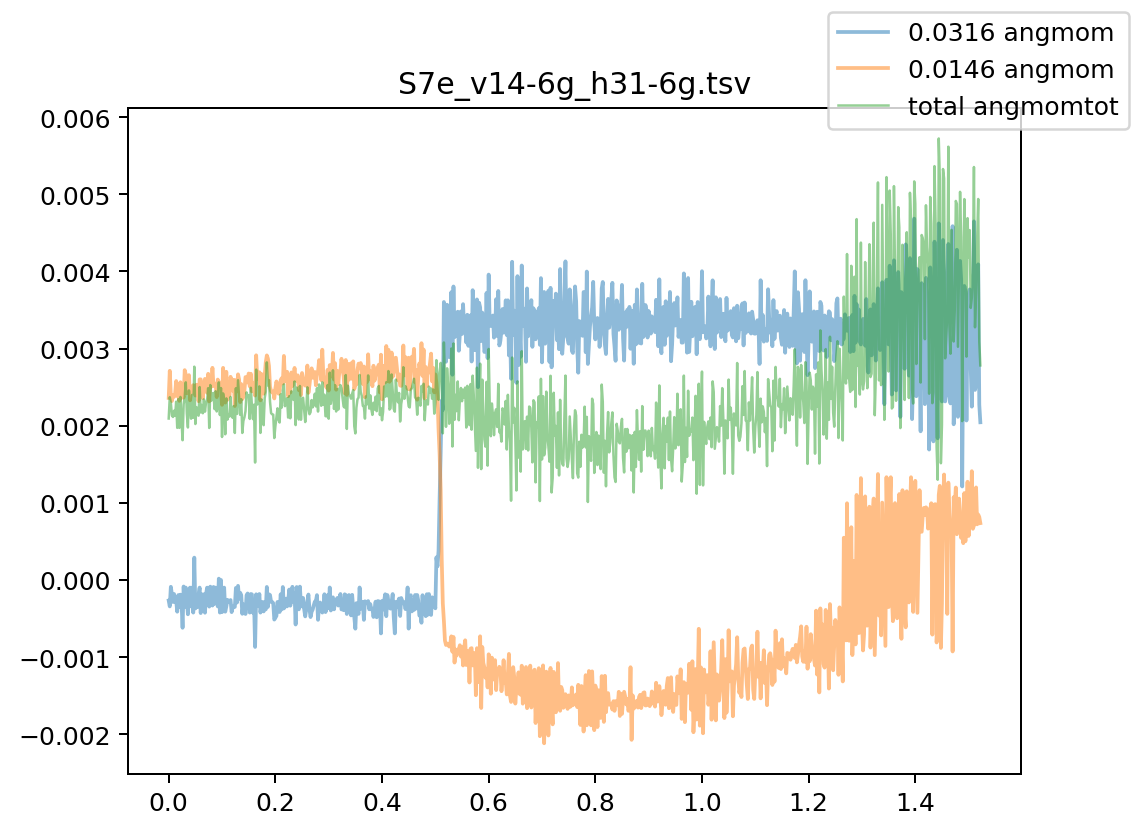

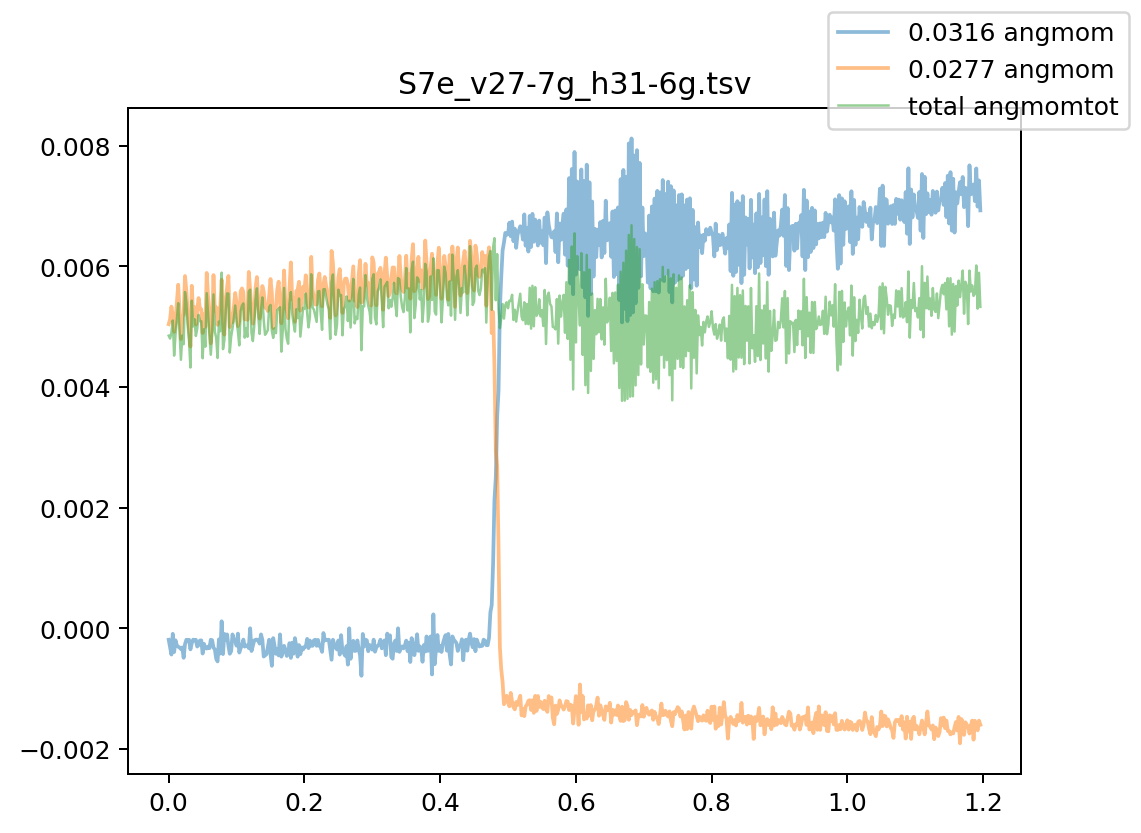

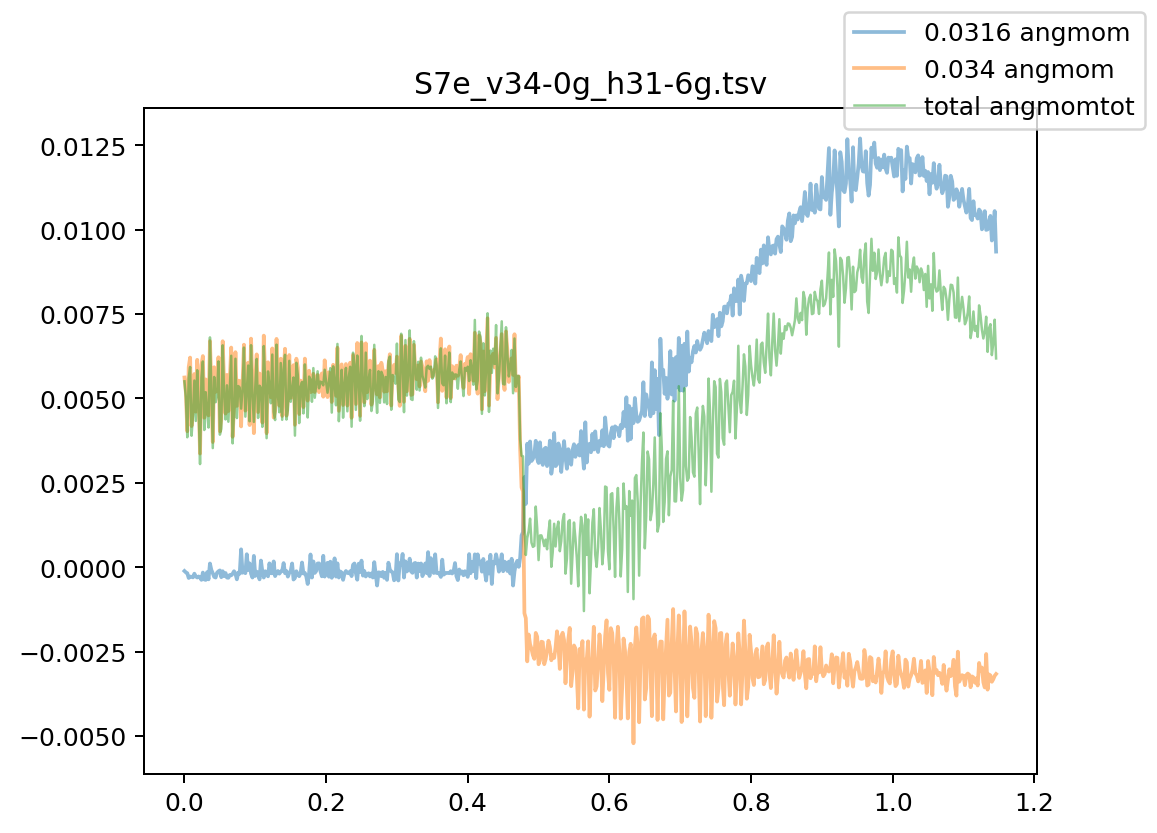

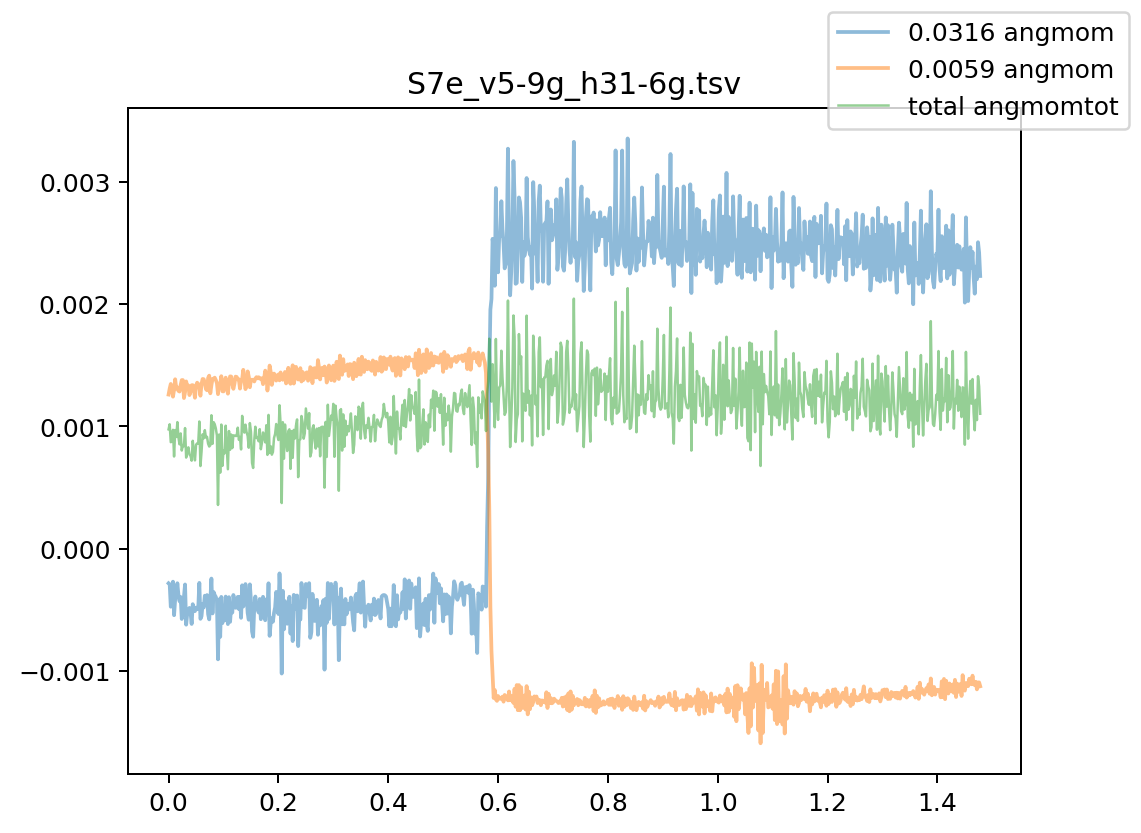

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import os
from parse_script import parse_marker_data
dir = 'data/S8'

moment_of_inertia = {"5.9": 3.084225e-6, "14.6": 4.5625e-6, "27.7": 8.65625e-6, "31.6": 0.00001315025, "34.0": 6.8e-6}

# Generate animations for all tsv files in data folder
for root, dirs, files in os.walk(dir):
    for file in files:
        if file.endswith('.tsv') and file.find('mag') == -1: # Ignore magnitudes data
            print("Generating plot from tsv file: ", file)
            markers_dict, ts, masses = parse_marker_data(root + '/' + file)
            fig = plt.figure(dpi=180)
            ax = fig.subplots()
            ax.set_title(file)
            rmm = False if file.find('1D') != -1 or (file.find('rm') != -1 and file.find('rmm') == -1) or file.find('vel') != -1 else True

            frequency = 500
            ts0 = np.array(ts[:-1]) - ts[0]
            angmomtot = np.zeros(len(ts0))
            extangmomtot = np.zeros(len(ts0))
            for name, mass in masses.items():
                xs, ys, zs = markers_dict[f"{name}cm"].T * 0.001
                rs = markers_dict[f"{name[0]}x"]
                r1s = rs[:-1]
                r2s = rs[1:]
                sign = np.array([1 if np.cross(r1, r2)[2] > 0 else -1 for r1, r2 in zip(r1s, r2s)])
                theta = sign*np.arcsin(np.array([np.linalg.norm(np.cross(r1, r2)) for r1, r2 in zip(r1s, r2s)])/(np.linalg.norm(r1s, axis=1)*np.linalg.norm(r2s, axis=1)))

                dxs = np.array(xs[1:])-np.array(xs[:-1])
                dys = np.array(ys[1:])-np.array(ys[:-1])
                dzs = np.array(zs[1:])-np.array(zs[:-1])
                mom = [moment_of_inertia[f"{name[1:]}"]]*len(xs[1:]) + mass*np.sqrt(xs[1:]**2+ys[1:]**2)
                extangmomsign = np.array([1 if np.cross(np.array([x,y,z]), mass*np.array([dx*frequency,dy*frequency, dz*frequency]))[2] > 0 else -1 for x, y, z, dx, dy, dz in zip(xs[1:], ys[1:], zs[1:], dxs, dys, dzs)])
                extangmom = extangmomsign * np.array([np.linalg.norm(np.cross(np.array([x,y,z]), mass*np.array([dx*frequency,dy*frequency, dz*frequency]))) for x, y, z, dx, dy, dz in zip(xs[1:], ys[1:], zs[1:], dxs, dys, dzs)])
                angmom = theta*mom*frequency
                angmomtot += angmom
                extangmomtot += extangmom
                
                ax.plot(ts0, angmom, alpha=0.5, label=f'{mass} angmom')
                #ax.plot(ts0, extangmom, alpha=0.5, label=f'{mass} extangmom')
                #ax.plot(ts0, extangmom, alpha=0.5, label=f'{mass} sum angmom')
            ax.plot(ts0, angmomtot, alpha=0.5, label=f'total angmomtot', linewidth=1.0)
            #ax.plot(ts0, angmomtot, alpha=0.5, label=f'total extangmomtot', linewidth=1.0)
            #ax.plot(ts0, extangmomtot + angmomtot, alpha=0.5, label=f'total total', linewidth=1.0)
            fig.legend()
            fig.savefig(f"angularmomentum/{file}.png")